# Urban Analysis with Google Satellite Embeddings


This notebook demonstrates how to use UrbanPy to download and analyze 
Google's satellite embeddings.


**Requirements:**
- Earth Engine account and authentication. See [auth guide](https://developers.google.com/earth-engine/guides/auth) for instructions.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys

sys.path.append("..")

import urbanpy as up
import geopandas as gpd
import numpy as np

import ee

import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [3]:
tqdm.pandas()

## 1. Download data for city and generate hexagons

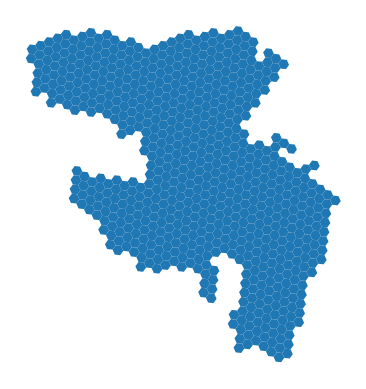

In [4]:
quito = up.download.nominatim_osm(
    "Distrito Metropolitano de Quito, Pichincha, Ecuador",
    email="your.email@example.com",
)
hexes = up.geom.gen_hexagons(resolution=7, city=quito)  # Resolution 7: ~5km² hexagons

hexes.plot()
plt.axis("off")
plt.show()

# 2. Download Satellite Embeddings

Satellite embeddings are 64-dimensional learned representations that capture
land surface characteristics from multi-sensor satellite data.

For each hexagon, we download the embeddings from Google Earth Engine, reducing all embeddings within the hexagon to a single vector. This allows us to get a representative embedding for the entire hexagon, making it easier to work with.

### Authenticate with Earth Engine

if this is the first time you use google earth engine you will have to create or specify a Google Cloud Console project and also enable Google Earth Engine for that project

In [ ]:
# Authenticate with Earth Engine
try:
    ee.Initialize(project="your-project-id")
except Exception:
    ee.Authenticate()  # one-time browser flow
    ee.Initialize(project="your-project-id")

### Download and validate embeddings

In [6]:
embeddings = up.download.google_satellite_embeddings(hexes, year=2023)

embedding_cols = [col for col in embeddings.columns if col.startswith("A")]
valid_hexes = embeddings[embedding_cols[0]].notna().sum()

print(
    f"Successfully downloaded embeddings for {valid_hexes}/{len(embeddings)} hexagons"
)

if valid_hexes == 0:
    raise ValueError(
        "No embedding data retrieved. Check Earth Engine authentication and project ID."
    )

embeddings.head()

Retrieved 718 features from Earth Engine
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-78.41946148607806, 0.2536015851221892], [-78.42738262018916, 0.24282279438815985], [-78.42178501599855, 0.23049327065624914], [-78.40826602515907, 0.22894359567292638], [-78.4003456886088, 0.23972315349669704], [-78.40594354493768, 0.2520516191920106], [-78.41946148607806, 0.2536015851221892]]]}, 'id': '0', 'properties': {'A00': -0.012210374338229935, 'A01': -0.015764855261631662, 'A02': 0.04762615786688245, 'A03': -0.04770823540875145, 'A04': 0.08285197717525639, 'A05': -0.04335812134456066, 'A06': 0.006646787979185214, 'A07': -0.01617137397154833, 'A08': 0.08927317324769073, 'A09': 0.005627673120217499, 'A10': -0.023712860665845863, 'A11': -0.0945642115890912, 'A12': -0.0027982057278485477, 'A13': 0.01746917590411954, 'A14': -0.06341975128630287, 'A15': -0.1638106124887473, 'A16': -0.20289126564137103, 'A17': -0.0503498925930657, 'A18': -0.08030380066276847, 'A19': -0.09045

,geometry,A00,A01,A02,A03,A04,A05,A06,A07,A08,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,hex
0,"POLYGON ((-78.41946 0.2536, -78.42738 0.24282,...",-0.012210,-0.015765,0.047626,-0.047708,0.082852,-0.043358,0.006647,-0.016171,0.089273,...,-0.167098,0.026739,-0.076119,-0.204360,-0.079301,-0.001414,0.121799,-0.155974,-0.290017,8766d3b94ffffff
1,"POLYGON ((-78.19861 -0.20457, -78.20653 -0.215...",-0.028306,-0.012854,-0.031651,-0.112338,-0.109440,0.055266,0.055814,-0.179529,0.194983,...,-0.186690,0.041453,-0.031675,-0.179936,-0.216983,0.002417,0.207639,-0.183270,-0.190025,8766d336bffffff
2,"POLYGON ((-78.37139 0.1195, -78.37931 0.10871,...",0.018828,0.027991,0.033058,-0.072527,0.065566,0.002892,0.091134,-0.072631,0.074903,...,-0.117045,0.055868,-0.039156,-0.217623,-0.099242,-0.020531,0.106371,-0.105937,-0.246816,8766d3aa2ffffff
3,"POLYGON ((-78.48232 -0.37154, -78.49026 -0.382...",0.028986,-0.041577,0.026822,-0.067836,0.079977,0.027906,0.064005,-0.072225,0.070828,...,-0.131100,0.047927,-0.056856,-0.226265,-0.131128,0.095357,0.063385,-0.095334,-0.256757,8766d32f2ffffff
4,"POLYGON ((-78.40857 -0.25094, -78.4165 -0.2617...",-0.000334,-0.016856,-0.024078,-0.059458,0.077509,0.027788,-0.022550,-0.039070,0.061152,...,-0.136492,0.044548,-0.090333,-0.212236,-0.154284,0.045116,0.071539,-0.110006,-0.327388,8766d3200ffffff


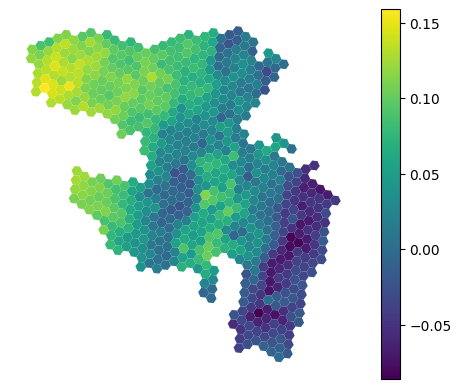

In [7]:
# Plot single band for visualization
embeddings.plot(column="A00", cmap="viridis", legend=True)
plt.axis("off")
plt.show()

# 3. Analysis
Satellite embeddings can be used for a variety of tasks, such as classification, similarity search, and regression.

## 3.1 Clustering


Counts per cluster:
 cluster
0    217
1    130
2    197
3    174 

Area (m²) per cluster:
 cluster
0    1.278967e+09
1    7.656591e+08
2    1.162534e+09
3    1.025621e+09 



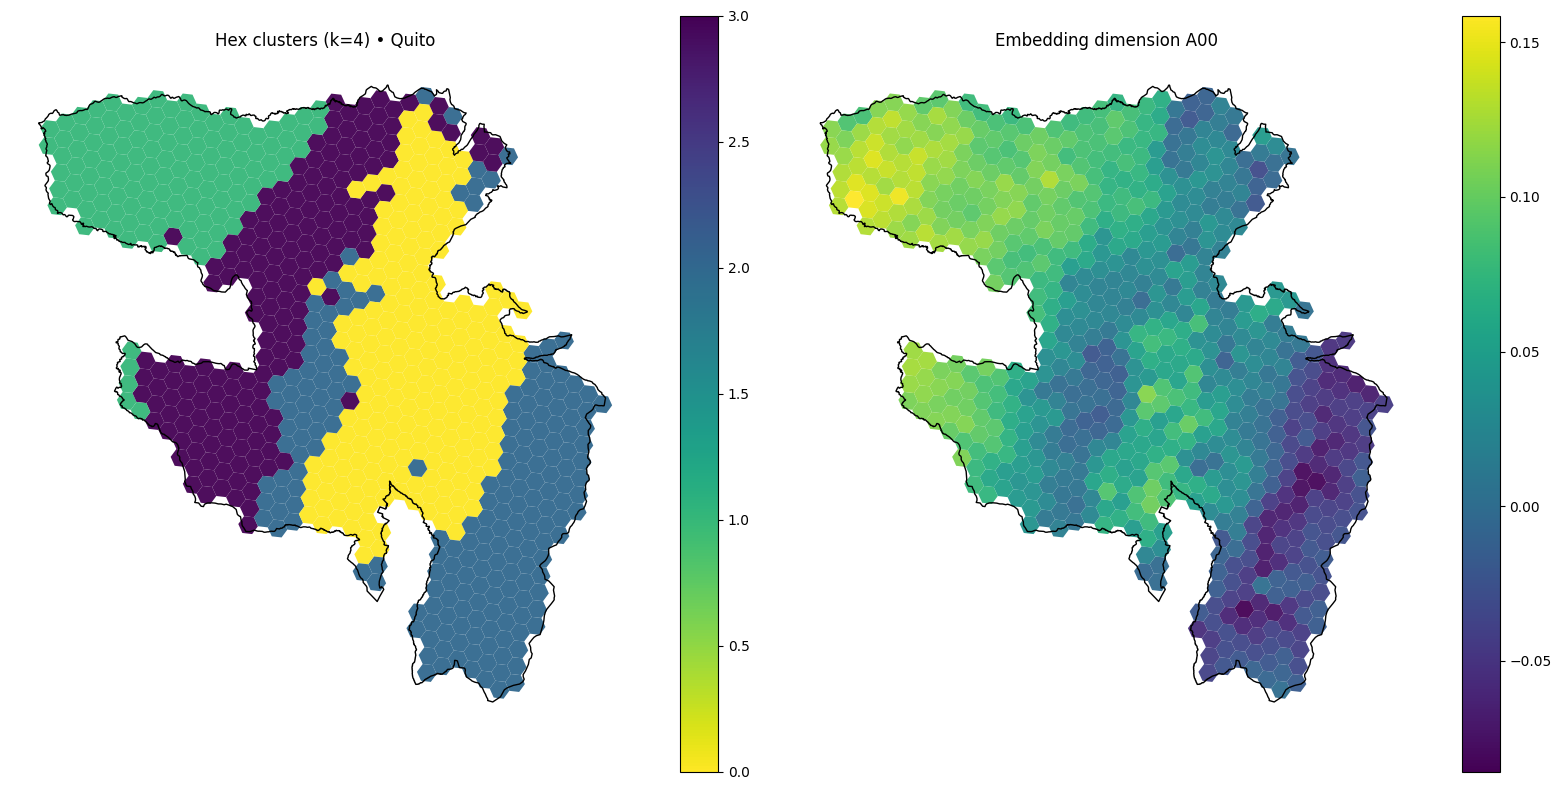

In [8]:
SEED = 33
K_CLUSTERS = 4
BAND_COLS = [f"A{str(i).zfill(2)}" for i in range(64)]

# clean and scale
embeddings = embeddings.dropna(subset=BAND_COLS).reset_index(drop=True)
X = embeddings[BAND_COLS].to_numpy(dtype=float)

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

km = KMeans(n_clusters=K_CLUSTERS, n_init=10, random_state=SEED)
labels = km.fit_predict(Xz)
embeddings["cluster"] = labels.astype(int)

# small summary
# project to a metric CRS, compute area, back to WGS84
emb_m = embeddings.to_crs(epsg=3857).copy()
emb_m["area_m2"] = emb_m.geometry.area
counts = emb_m["cluster"].value_counts().sort_index()
areas = emb_m.groupby("cluster")["area_m2"].sum().sort_index()
print("Counts per cluster:\n", counts.to_string(), "\n")
print("Area (m²) per cluster:\n", areas.round(0).to_string(), "\n")

# plot clusters + one band
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

embeddings.plot(
    column="cluster", legend=True, alpha=0.95, linewidth=0, cmap="viridis_r", ax=ax1
)
gpd.GeoDataFrame(geometry=quito.geometry).boundary.plot(
    ax=ax1, color="black", linewidth=1.0
)
ax1.set_title(f"Hex clusters (k={K_CLUSTERS}) • Quito")
ax1.set_axis_off()

embeddings.plot(
    column="A00", legend=True, alpha=0.95, linewidth=0, cmap="viridis", ax=ax2
)
gpd.GeoDataFrame(geometry=quito.geometry).boundary.plot(
    ax=ax2, color="black", linewidth=1.0
)
ax2.set_title("Embedding dimension A00")
ax2.set_axis_off()

plt.tight_layout()

plt.show()

## 3.2 Similarity Search

Top-5 most similar hex indices:
  similarity  idx
   1.000000   90
   0.979931  532
   0.964643  308
   0.964619  529
   0.958276  223 



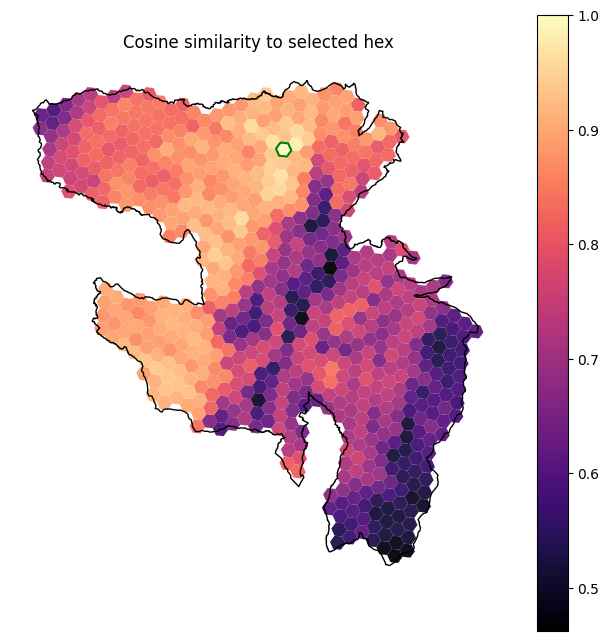

In [9]:
# choose a hex index to compare
hex_idx = min(90, len(embeddings) - 1)

v = embeddings.iloc[hex_idx][BAND_COLS].to_numpy(dtype=float).reshape(1, -1)
X = embeddings[BAND_COLS].to_numpy(dtype=float)
sims = cosine_similarity(X, v).ravel()

embeddings["similarity"] = sims

top5 = (
    embeddings[["similarity"]]
    .assign(idx=np.arange(len(embeddings)))
    .sort_values("similarity", ascending=False)
    .head(5)
)
print("Top-5 most similar hex indices:\n", top5.to_string(index=False), "\n")

# plot
fig, ax = plt.subplots(figsize=(8, 8))
embeddings.plot(
    column="similarity", legend=True, alpha=0.95, linewidth=0, ax=ax, cmap="magma"
)
gpd.GeoDataFrame(geometry=quito.geometry).boundary.plot(
    ax=ax, color="black", linewidth=1.0
)
embeddings.iloc[[hex_idx]].boundary.plot(ax=ax, color="green", linewidth=1.5)
ax.set_title("Cosine similarity to selected hex")
ax.set_axis_off()
plt.show()